# func Development
## Final Project - Team 5
### PHYS-352 Winter 2021
## Orion Forowycz

# Initial Setup

In [67]:
#!gcc -shared -O2 -fPIC ode.c -o libode.so

In [68]:
import ctypes
from ctypes import *
from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
import numba
import math

In [69]:
from ode_solver import *
from helpers import *

# func Setup

In [70]:
from numba import cfunc, types

c_sig = types.void(types.double,
                   types.CPointer(types.double),
                   types.CPointer(types.double),
                   types.CPointer(types.double))

@cfunc(c_sig)
def func(t,a,params,dydt):
    """
    Takes the time and solution vector y, as well as parameters in the params array,
    and populates the dydt array with the values of the right-hand side function 
    f(t,y).
    Returns: nothing
    """

    #Particle Input
    x = a[0]
    v_x = a[1]
    y = a[2]
    v_y = a[3]
    GM_S = params[0]
    r = np.sqrt(x**2 + y**2)

    #Jupiter
    GM_J = params[1]
    r_J = params[2]
    period_J = params[3]
    theta_J = 2*np.pi*t/period_J
    x_J = r_J*np.cos(theta_J)
    y_J = r_J*np.sin(theta_J)
    x_diff = x - x_J
    y_diff = y - y_J
    r_diff = np.sqrt(x_diff**2 + y_diff**2)
    
    #Particle Output
    dydt[0] = v_x #dx/dt
    dydt[1] = -GM_S/(r**3)*x - GM_J/(r_diff**3)*x_diff #dv_x/dt
    dydt[2] = v_y #dy/dt
    dydt[3] = -GM_S/(r**3)*y - GM_J/(r_diff**3)*y_diff #dv_y/dt

# func Testing

In [71]:
GM_S = 39.4229 #AU^3.yr^{-2} solar mass parameter

a_0 = 0.39
e_0 = 0.206
theta_E_0 = -3*np.pi/4
theta_0 = theta_E_0
x_0,v_x_0,y_0,v_y_0 = ellipse_to_xy(a_0, e_0, theta_0, theta_E_0, GM_S)
initial_mercury = [x_0,v_x_0,y_0,v_y_0]

In [72]:
total_time = 10*orbital_period(a_0,GM_S)
step_size = orbital_period(a_0,GM_S)/400
nsteps = int(total_time/step_size)
t,sol = solve_ode(func,[0.,total_time], nsteps, initial_mercury, args=[GM_S], method="RK4")
x,v_x,y,v_y = sol.T

theta_E_i_no_jupiter = [0] * len(t)
for i in range(len(t)):
    a, e, theta, theta_E = xy_to_ellipse(x[i],v_x[i],y[i],v_y[i],GM_S)
    theta_E_i_no_jupiter[i] = theta_E

Text(0.5, 1.0, 'Mercury Orbiting Sun Without Jupiter (4000 orbital periods)')

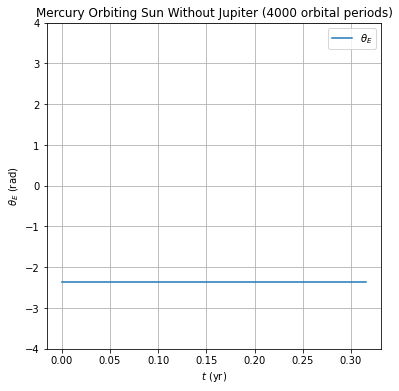

In [73]:
plt.figure(figsize=(6,6))
plt.plot(t,theta_E_i_no_jupiter,label=r"$\theta_E$")
plt.legend()
plt.ylim(-4,4)
plt.grid()
plt.xlabel(r"$t$ (yr)")
plt.ylabel(r"$\theta_E$ (rad)")
plt.title(r"Mercury Orbiting Sun Without Jupiter (4000 orbital periods)")